# Filtering all dates, writing a file containing filtered data and plotting results



__source__ : copy 2017-05-04-AA-make-2D-filt-write-file-and-plot-n30.ipynb with different size of window for Lanczos filtering and cut-off frequency

## 1. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.1
xarray 0.9.1
netCDF4 1.2.4
Fri May 05 09:47:57 2017 CEST

In [1]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [2]:
## imports

import numpy as np
import dask
import xarray as xr
import GriddedData
import time

In [3]:
#- Other modules
import os
from glob import glob
import numpy.ma as ma
import scipy as sc
import WavenumberSpectrum as ws
import dask.array as da
from netCDF4 import Dataset

### palette
from matplotlib.colors import LogNorm
import matplotlib.cm as mplcm
import colormap as cmaps
import matplotlib.cm as cm

import seaborn as sns

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf
%matplotlib inline

## 2. Dataset

In [4]:
dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/"
files01="NATL60-CJM165_y2013m01d*.1d_curloverf.nc"
files02="NATL60-CJM165_y2013m02d*.1d_curloverf.nc"
files03="NATL60-CJM165_y2013m03d*.1d_curloverf.nc"
files09="NATL60-CJM165_y2013m09d*.1d_curloverf.nc"

tfiles01=dir+files01
tfiles02=dir+files02
tfiles03=dir+files03
tfiles09=dir+files09

!ls $tfiles02


/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d01.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d02.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d03.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d04.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d05.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d06.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d07.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d08.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d09.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d10.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d11.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m02d12.1d_curloverf.nc
/med

## 4. 2D filtering

In [7]:
gridfile="/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']
sh=navlat.shape
xdim=sh[0]
ydim=sh[1]
print xdim,ydim

/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc
3454 5422


In [5]:
gridfile="/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']

def plot_and_save_curl_total_filt(curl,signal_LS,t,month):
    cont=np.isnan(curl)
    plt.figure(figsize=(15,33))
    ax = plt.subplot(311)
    ax.autoscale(tight=True)
    pcolor = ax.pcolormesh(navlon,navlat,
      ma.masked_invalid(curl),cmap=div_cmap,vmin=-1,vmax=1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.title('Total surface relative vorticity '+str(t)+' month '+str(month),fontsize=25)
    cont=np.isnan(signal_LS)
    ax = plt.subplot(312)
    ax.autoscale(tight=True)
    pcolor = ax.pcolormesh(navlon,navlat,
      ma.masked_invalid(signal_LS),cmap=div_cmap,vmin=-1,vmax=1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.title('Large scale surface relative vorticity '+str(t)+' month '+str(month),fontsize=25)
    signal_SS=curl-signal_LS
    cont=np.isnan(signal_SS)
    ax = plt.subplot(313)
    ax.autoscale(tight=True)
    pcolor = ax.pcolormesh(navlon,navlat,
      ma.masked_invalid(signal_SS),cmap=div_cmap,vmin=-1,vmax=1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.title('Small scale surface relative vorticity '+str(t)+' month '+str(month),fontsize=25)
    figname='/media/extra/DATA/NATL60/NATL60-CJM165-PLOTS/filt_socurloverf/filtering_socurloverf_NATL60-CJM165_'+str(t)+'0'+str(month)+'.png'
    plt.savefig(figname)
    

/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc


In [1]:
tfiles

NameError: name 'tfiles' is not defined

29
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d30.1d_socurloverf_filt2deg_fc80-n80.nc


/home/albert/lib/python/oocgcm-0.1.0-py2.7.egg/oocgcm/filtering/linearfilters.py:58: RuntimeWarning: invalid value encountered in divide
  np.sin(np.pi * k / (n / 2.)) / (np.pi * k / (n / 2.)))


[########################################] | 100% Completed |  7min 45.3s
30
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d31.1d_socurloverf_filt2deg_fc80-n80.nc
[########################################] | 100% Completed |  7min 49.4s


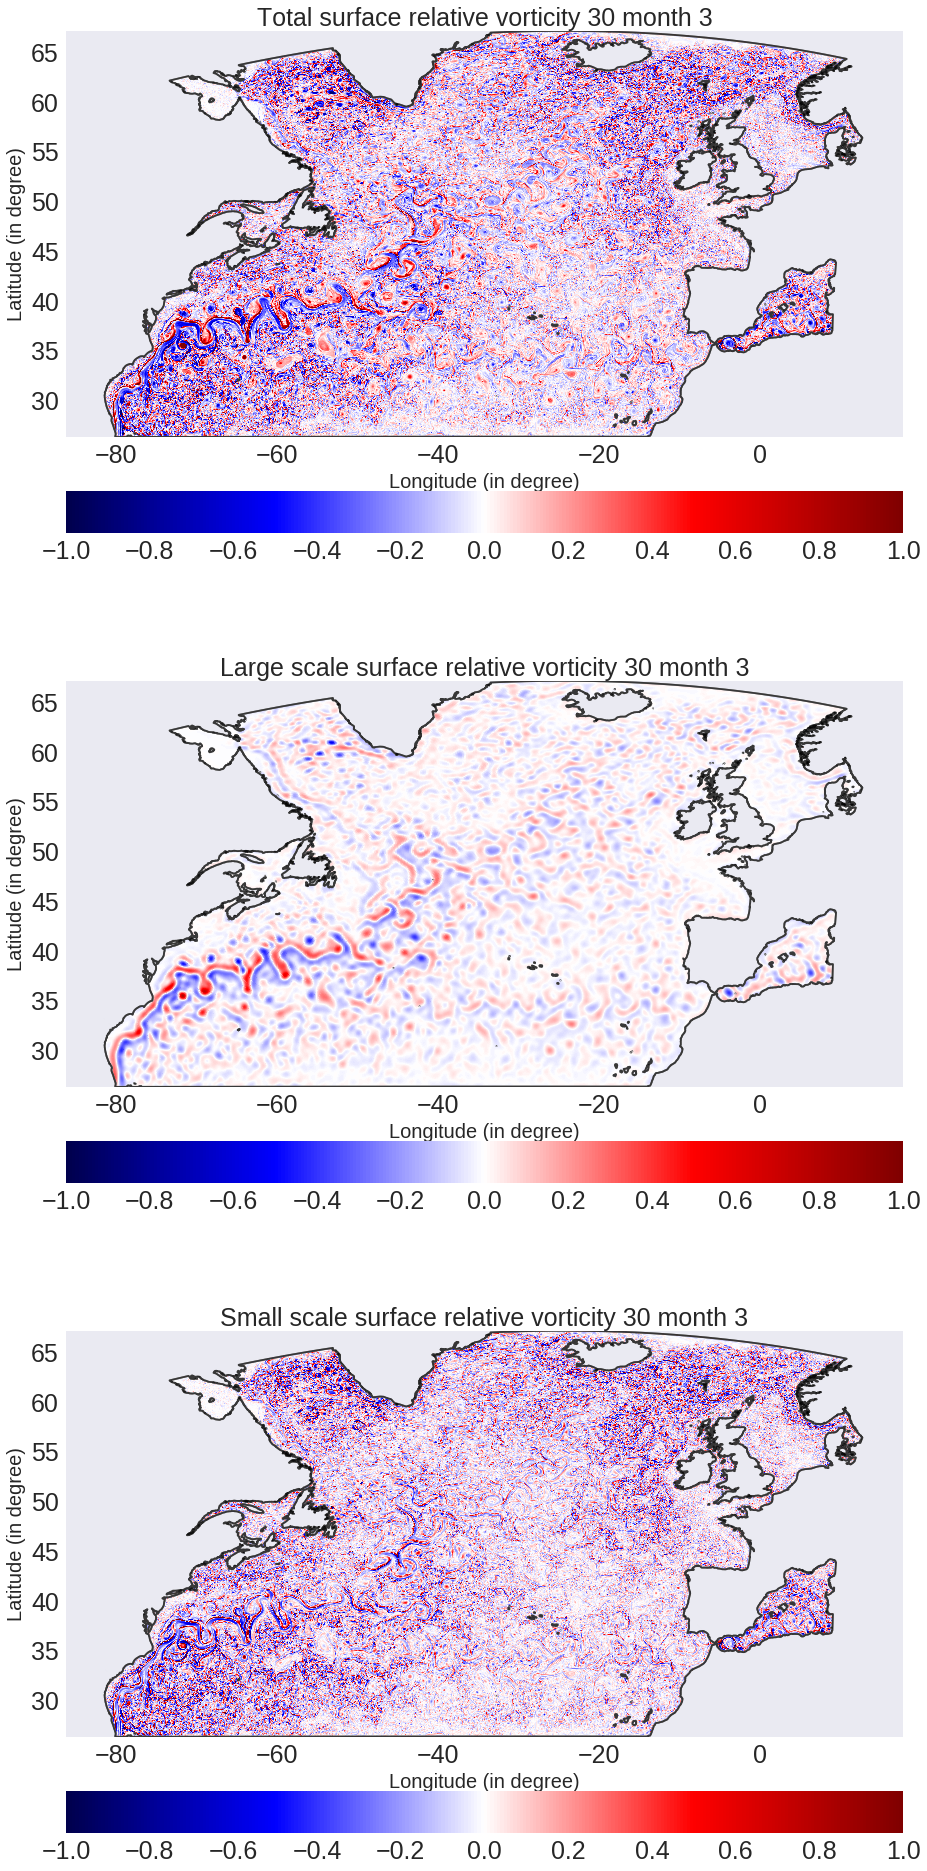

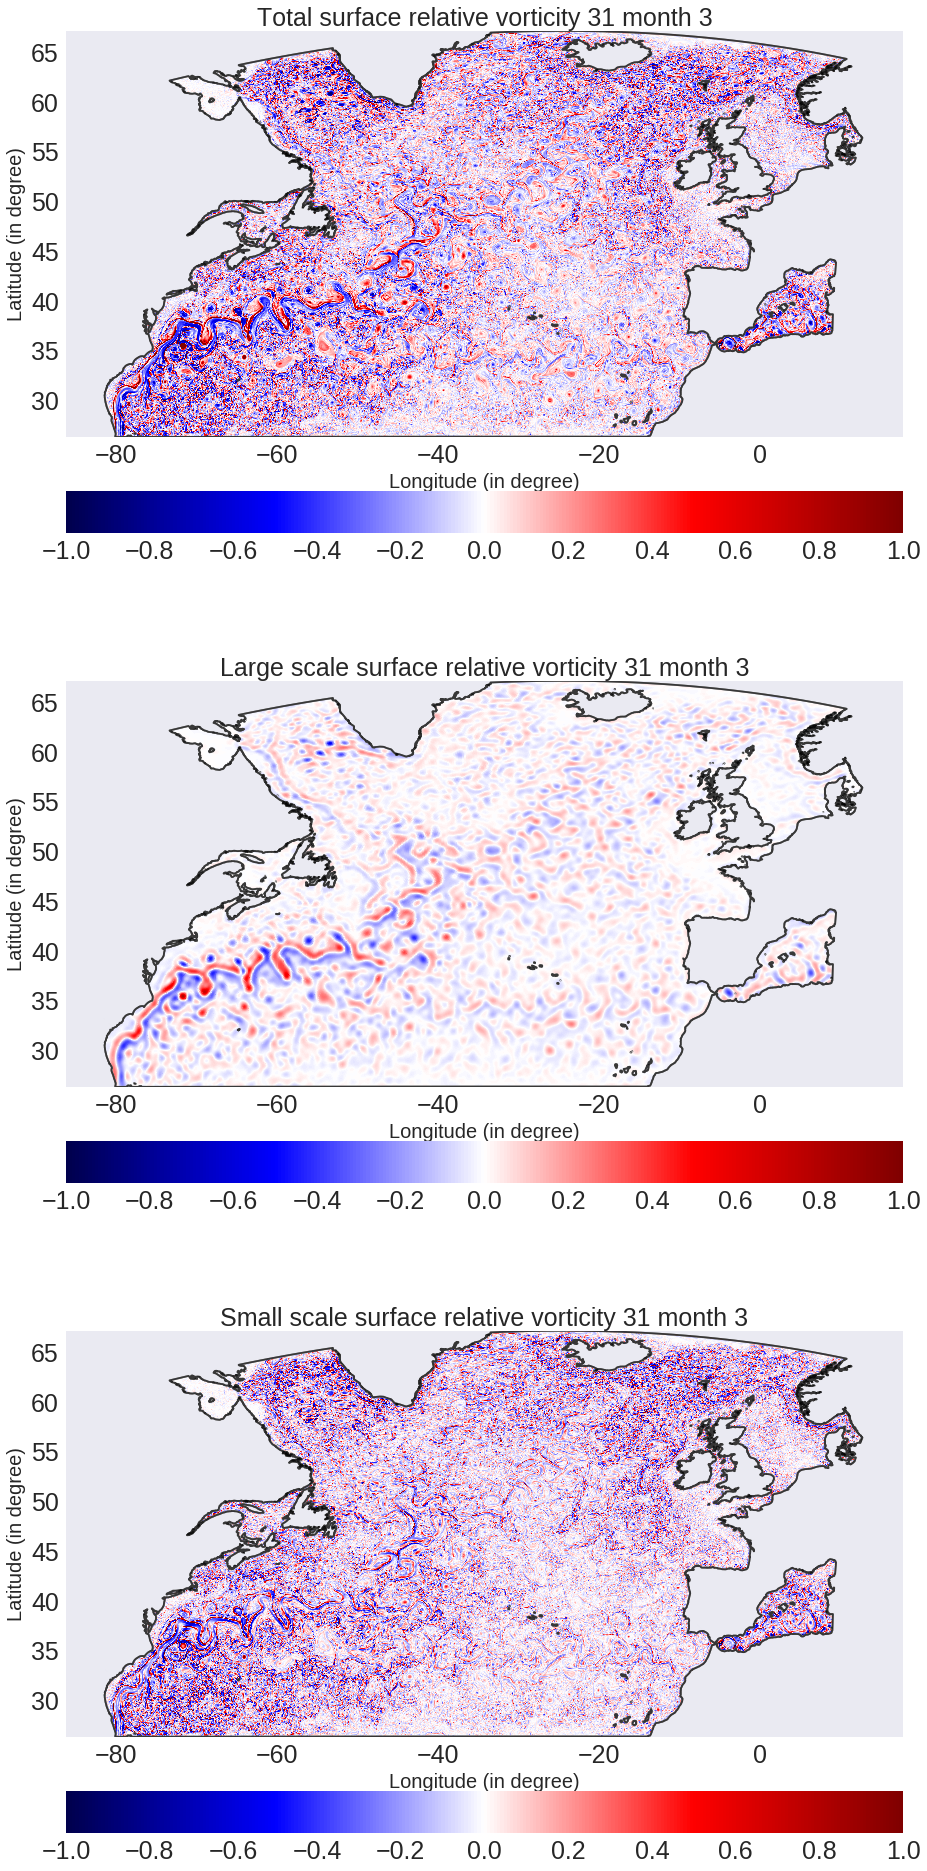

In [6]:
month=3
tfiles=tfiles03

curls = xr.open_mfdataset(tfiles,concat_dim='time_counter')['socurloverf']


for t in np.arange(29,31):
    print t
    filename='/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m0'+str(month)+'d'+str(t+1)+'.1d_socurloverf_filt2deg_fc80-n80.nc'
    print filename
    filtset = Dataset(filename, 'w', format='NETCDF4')
    filtset.description = "NATL60 data filtered with Lanczos filter with cut-off frequency of 1deg1/3"
    
-
    del curl0,win_box2D,bw,signal_LS,signal_SS,truc